# Problem Statement

Carvana, an online used car retailer, has took pictures of used cars using their custom rotating photo studio that automatically captures and processes 16 standard images of each vehicle in their inventory. While Carvana takes high quality photos, bright reflections and cars with similar colors as the background cause automation errors, which requires a skilled photo editor to change.

In this Kaggle challenge, the objective is to develop an algorithm that automatically removes the photo studio background. This will allow Carvana to superimpose cars on a variety of backgrounds. The dataset, which is obtained from Kaggle, consists of photos covering different vehicles with a wide variety of year, make, and model combinations.

The approach is to build a UNet Convolutional Neural Network (UNet-CNN) model to predict a mask image from the images. Along the process the UNet CNN will be optimized.


[Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/overview)

# Abstract

A total of 4 models are built. They are MobileNetV2 + pix2pix no optimization, MobileNetV2 + pix2pix with optimization, VGG19 + pix2pix with optimization and CNN UNet built from scratch. Only 2 models, MobileNetV2 + pix2pix no optimization, MobileNetV2 + pix2pix with optimization are trained due to limited computational power and time constraint. Training of the models and run length encoding is done on a local machine. Another objective is to see if a short UNet CNN can be build and trained on a local machine but training took considerable time. Both models that are trainable took 3 hours to train. Run length encoding of predicted masks from test images took around 3.5 hours.

The Kaggle score obtained is around 0.52. As this is my first project with Image Segmentation, there are many factors that could be further considered and tweaked, such as weight initialization to optimize the models. Another improvement that can be done is to search for platforms to train the models to reduce training time.

# Import Libraries

In [1]:
# import tensorflow
import tensorflow as tf

# numpy for math functions etc
import numpy as np

#pd for pandas
import pandas as pd

# random from python core
import random as rnd

# import keras
from tensorflow import keras
from tensorflow.keras import layers

# set seed for python core
rnd.seed(123)

# set seed for numpy, keras takes random number generator from numpy
np.random.seed(123)

# set seed for tensorflow
tf.random.set_seed(1234)

# neural network modules
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.math import *
from tensorflow.keras.metrics import *

# PILLOW; python imaging library
from PIL import Image

# plotting graphs
from matplotlib import pyplot as plt

# import OS
import os
# import Path from pathlib
from pathlib import Path as path

# other modules
from sklearn.model_selection import train_test_split
import timeit

# Path to data folders

In [2]:
# define file paths

root_dir = path("./data_lq")
train_data = path.joinpath(root_dir, "train")  # relative path for train dataset
test_data = path.joinpath(root_dir, "test")   # relative path for test dataset
mask_data = path.joinpath(root_dir, "train_masks")  #relative path for mask data

- Path class is used to path to the train, test and mask folders on the local drive.
- Path converts windows path format to UNIX path format.

## Look through train, test and mask data

**Check number of files in each dataset**

In [3]:
# no. of images in train data
len(os.listdir(train_data))

5088

In [4]:
# no. of images in test data
len(os.listdir(test_data))

100064

In [5]:
# no. of images in mask data
len(os.listdir(mask_data))

5088

- In the train and test data that contain low resolution pictures, there are 5088 files in the train dataset and 100,064 files in the test data set. There are a lot more images in test than in train.
- There is also train and test data that contain high resolution pictures. I will be utilizing the low resolution images.
- Images for train data are in `.jpg` format and `.gif` format for mask data.

In [6]:
# no. of different cars in train
len(set([file.split('_')[0] for file in os.listdir(train_data)]))

318

In [7]:
# no. of different cars in test
len(set([file.split('_')[0] for file in os.listdir(test_data)]))

6254

In [8]:
# no. of different cars in mask
len(set([file.split('_')[0] for file in os.listdir(mask_data)]))

318

- There are 318 different cars in train and mask data.
- There are 6254 different cars in test data.

# Create tensorflow datasets from directories
- File paths for images in train and mask data will be put into a pandas dataframe.
- Train_test_split will be used to split the pandas dataframe into training and validation data.
- Tensorflow dataset for training and tensorflow dataset for validation are created.
- Validation data serves as unseen data to validate the performance of the CNN later.

## Create pandas dataframe containing file paths

In [9]:
# create dataframe with train, train_masks, car_id
df = pd.DataFrame({'train_path': [str(path.joinpath(train_data, file)) for file in os.listdir(train_data)],
                    'car_id': [file.split('_')[0] for file in os.listdir(train_data)],
                    'mask_path': [str(path.joinpath(mask_data, file)) for file in os.listdir(mask_data)],
                    'mask_id': [file.split('_')[0] for file in os.listdir(mask_data)]})

- File paths for images in train and mask are put into pandas dataframe

In [10]:
# show dataframe
df.head(17)

train_path        car_id  \
0   data_lq\train\00087a6bd4dc_01.jpg  00087a6bd4dc   
1   data_lq\train\00087a6bd4dc_02.jpg  00087a6bd4dc   
2   data_lq\train\00087a6bd4dc_03.jpg  00087a6bd4dc   
3   data_lq\train\00087a6bd4dc_04.jpg  00087a6bd4dc   
4   data_lq\train\00087a6bd4dc_05.jpg  00087a6bd4dc   
5   data_lq\train\00087a6bd4dc_06.jpg  00087a6bd4dc   
6   data_lq\train\00087a6bd4dc_07.jpg  00087a6bd4dc   
7   data_lq\train\00087a6bd4dc_08.jpg  00087a6bd4dc   
8   data_lq\train\00087a6bd4dc_09.jpg  00087a6bd4dc   
9   data_lq\train\00087a6bd4dc_10.jpg  00087a6bd4dc   
10  data_lq\train\00087a6bd4dc_11.jpg  00087a6bd4dc   
11  data_lq\train\00087a6bd4dc_12.jpg  00087a6bd4dc   
12  data_lq\train\00087a6bd4dc_13.jpg  00087a6bd4dc   
13  data_lq\train\00087a6bd4dc_14.jpg  00087a6bd4dc   
14  data_lq\train\00087a6bd4dc_15.jpg  00087a6bd4dc   
15  data_lq\train\00087a6bd4dc_16.jpg  00087a6bd4dc   
16  data_lq\train\02159e548029_01.jpg  02159e548029   

                                       mask_path       mask_id  
0   data_lq\train_masks\00087a6bd4dc_01_mask.gif  00087a6bd4dc  
1   data_lq\train_masks\00087a6bd4dc_02_mask.gif  00087a6bd4dc  
2   data_lq\train_masks\00087a6bd4dc_03_mask.gif  00087a6bd4dc  
3   data_lq\train_masks\00087a6bd4dc_04_mask.gif  00087a6bd4dc  
4   data_lq\train_masks\00087a6bd4dc_05_mask.gif  00087a6bd4dc  
5   data_lq\train_masks\00087a6bd4dc_06_mask.gif  00087a6bd4dc  
6   data_lq\train_masks\00087a6bd4dc_07_mask.gif  00087a6bd4dc  
7   data_lq\train_masks\00087a6bd4dc_08_mask.gif  00087a6bd4dc  
8   data_lq\train_masks\00087a6bd4dc_09_mask.gif  00087a6bd4dc  
9   data_lq\train_masks\00087a6bd4dc_10_mask.gif  00087a6bd4dc  
10  data_lq\train_masks\00087a6bd4dc_11_mask.gif  00087a6bd4dc  
11  data_lq\train_masks\00087a6bd4dc_12_mask.gif  00087a6bd4dc  
12  data_lq\train_masks\00087a6bd4dc_13_mask.gif  00087a6bd4dc  
13  data_lq\train_masks\00087a6bd4dc_14_mask.gif  00087a6bd4dc  
14  data_lq\train_masks\00087a6bd4dc_15_mask.gif  00087a6bd4dc  
15  data_lq\train_masks\00087a6bd4dc_16_mask.gif  00087a6bd4dc  
16  data_lq\train_masks\02159e548029_01_mask.gif  02159e548029

- Unique car id is selected from the file names.
- Each car has 16 images taken at different angles.

### Split data in dataframe into training and validation data

In [11]:
# split cars using car id and put into list first

car_id = list(set([file.split('_')[0] for file in os.listdir(train_data)]))
train_lst, val_lst = train_test_split(car_id, train_size=0.8, random_state=42, test_size=0.2)
print(f'There are {len(train_lst)} unique car ids in list of car ids split out for training data.')
print(f'There are {len(val_lst)} unique car ids in list of car ids split out for validation data.')

There are 254 unique car ids in list of car ids split out for training data.
There are 64 unique car ids in list of car ids split out for validation data.


In [12]:
# create training dataframe
train_df = df[df['car_id'].isin(train_lst)]
train_df.shape

(4064, 4)

- There are 4064 files in the training dataframe for 254 cars.

In [13]:
# create validation dataframe
val_df = df[df['car_id'].isin(val_lst)]
val_df.shape

(1024, 4)

- There are 1024 files in the validation dataframe for 64 cars.

- 254 cars are used for training and 64 cars are used for validation.

## Create training and validation tensorflow dataset

In [71]:
# create training and validation tensorflow dataset
# from_tensor_slices is used so that data can feed in batches
# from_tensors feed all of the data into the model and not able to split into batches
train_tf = tf.data.Dataset.from_tensor_slices((train_df['train_path'].values, train_df['mask_path'].values))
val_tf = tf.data.Dataset.from_tensor_slices((val_df['train_path'].values, val_df['mask_path'].values)) 

**Create function to process training and validation tensorflow dataset**

In [72]:
IMG_SIZE = [224,224]
batch_size = 8

def decode(path):
    
    # take in path string
    img = tf.io.read_file(path) 
    
    # convert the compressed string to a 3D uint8 tensor
    # must use decode_jpeg method to return tensor shape, to resize image later
    # tf.image.decode_image method does not return tensor shape
    img = tf.image.decode_jpeg(img, channels=3)
    
    # original size (1918, 1280)
    # resize to square (1024, 1024)
    img = tf.image.resize(img, IMG_SIZE)
    
    # scale the RGB values so that the values are normalized between 0 and 1
    img = img / 255.0
    return img

@tf.function  # designates below function as tensorflow function so that it is independent of python
def preprocess(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    image = decode(image_path)
    mask = decode(mask_path)
    mask = mask[:, :, :1]  # take only 1 channel
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

@tf.function  # designates below function as tensorflow function so that it is independent of python
def data_augmentation(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image_path)
        mask = tf.image.flip_left_right(mask_path)
        
    else:
        image = tf.image.flip_up_down(image_path)        
        mask = tf.image.flip_up_down(mask_path)
        
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

def batch_data(dataset):
    dataset = dataset.cache().batch(batch_size)
    dataset = dataset.prefetch(buffer_size=1)
    return dataset

In [73]:
# process training and validation tensorflow data
train_tf = train_tf.map(preprocess)
train_tf = train_tf.map(data_augmentation)
train_tf = batch_data(train_tf)

val_tf = val_tf.map(preprocess)
val_tf = batch_data(val_tf)

In [74]:
train_tf

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

- When not iterated through, train_tf batching will not be available.

# Display image and True mask

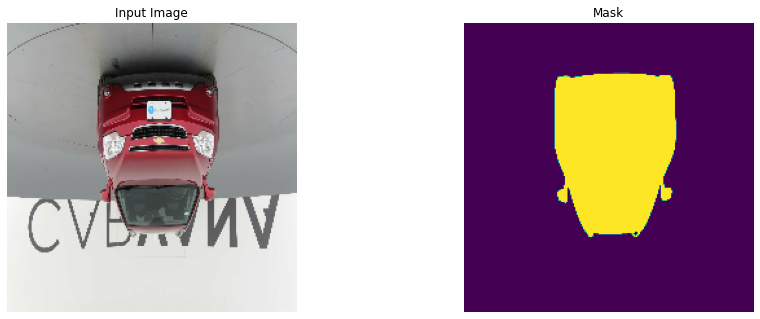

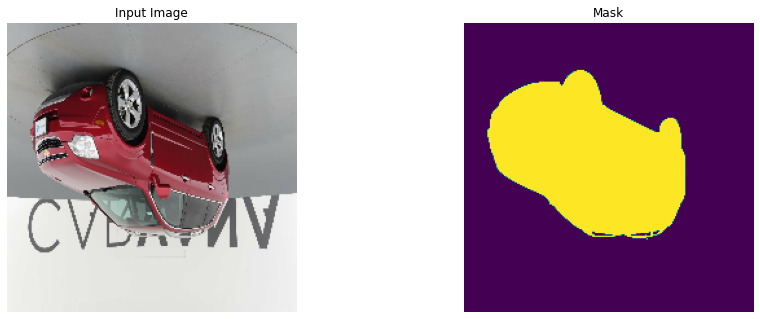

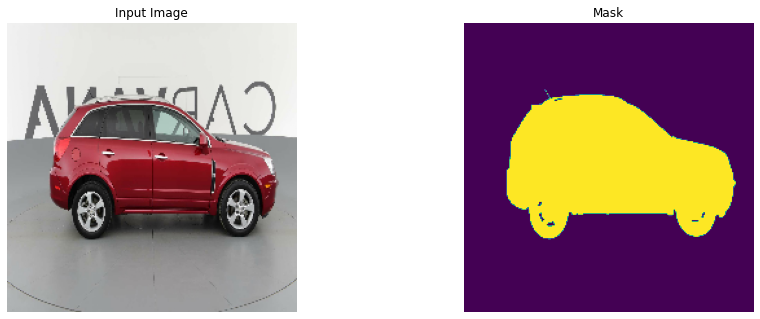

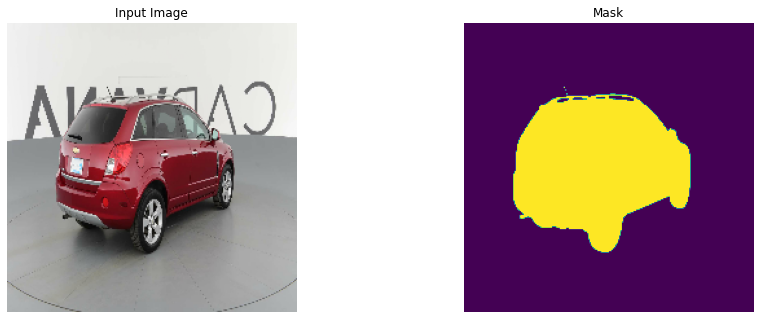

In [18]:
image, mask = next(iter(train_tf))

for i in range(0, 8, 2):

    plt.figure(figsize=(15, 50))
    plt.tight_layout()
    title = ['Input Image', 'Mask']

    plt.subplot(8, 2, i+1)
    plt.title(title[0])
    plt.imshow(image[i])
    plt.axis("off")

    plt.subplot(8, 2, i+2)
    plt.title(title[1])
    plt.imshow(mask[i])
    plt.axis("off")
    plt.show()




# Define UNet CNN model - transfer learning
# MobilenetV2 + pix2pix `no optimization`
- model is taken from TensorFlow Image Segmentation tutorial
- the encoder layers are obtained from the MobileNetV2 neural net
- the decoder layers are obtained from Tensorflow pix2pix example

## Define downsampler encoder

In [19]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape= input_shape, include_top=False)

# Use the activations of these layers
layer_names = [              # output shapes
    'block_1_expand_relu',   # (112, 112, 96)
    'block_3_expand_relu',   # (56, 56, 144)
    'block_6_expand_relu',   # (28, 28, 192)
    'block_13_expand_relu',  # (14, 14, 576)
    'block_16_project',      # (7, 7, 320)
]
downstack_layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs= downstack_layers)

down_stack.trainable = False

In [20]:
# output shape for each downstack layer
downstack_layers

[<KerasTensor: shape=(None, 112, 112, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 56, 56, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 28, 28, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 14, 14, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 7, 7, 320) dtype=float32 (created by layer 'block_16_project')>]

- The downsampler encoder will be layers derived from pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. 
- The encoder will not be trained during the training process, trainable will be set to `False`.
- The output shape for each of the downstack layer are shown above.

## Define upsampler decoder

In [21]:
from tensorflow_examples.models.pix2pix import pix2pix

# upsampler function arguments
# Conv2DTranspose => Batchnorm => Dropout => Relu
# Args:
# filters: number of filters
# size: filter size
# norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
# apply_dropout: If True, adds the dropout layer

# upsampler function is using a Conv2DTranspose with strides = 2,2 to half the size of the image

up_stack = [                   # output shapes
    pix2pix.upsample(512, 3),  # (14, 14, 512)
    pix2pix.upsample(256, 3),  # (28, 28, 256)
    pix2pix.upsample(128, 3),  # (56, 56, 128)
    pix2pix.upsample(64, 3),   # (112, 112, 64)
]

- The decoder will be the upsample block that is already implemented Pix2Pix in TensorFlow Examples.
- pix2pix.upsample is a function from the model built in tensorflow example.
- The number of filters and filter shape is optimized for the tensorflow image segmentation tutorial.

## Define callbacks

In [23]:
sample_image = image[1]
sample_mask = mask[1]

# this callback will show the prediction after every 4 epochs
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)

In [24]:
# this callback will stop the training if there are no improvements to the val_loss score
# after 4 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True,
                                                    monitor='val_loss')

**Function for showing prediction during callback**

In [25]:
def create_mask(pred_mask):
    # axis = -1 or axis = 4 is the last dimension of the 4D array, shape returned=(1,224,224)
    # zero is taken to be black, and 255 is taken to be white, since values are scaled between 0 and 1,
    # 0 = black, 1 = white.
    # tf.argmax returns the INDEX of the largest pixel values in the specified axis, 
    # if there are no largest values or it's a tie it will return the smallest value, in this case 0
    # values returned will be either 0 or 1 because in this layer it indicates if the pixel is a colored pixel (1)
    # or if it is background (0)
    
    # by using values from this code, ultimately it will indicate which pixel is black and which is white, hence 
    # creating a 1 channel mask
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    # adds a new axis to the back of the array (1, 224, 224, 1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    # returns (224, 224, 1) so that image can be plotted
    return pred_mask[0]

def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = create_mask(model_tl1.predict(sample_image[tf.newaxis, ...]))
    visualize([sample_image, sample_mask, pred_mask])

**Show how the mask is created**

In [19]:
# codes for loading a saved model  (commented out to prevent loading)
# save_model_v2pix2pix = path('./models/v2_pix2pix')
# v2pix2pix_trained = tf.keras.models.load_model(save_model_v2pix2pix)

In [139]:
# model output
v2pix2pix_trained.output

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_transpose_4')>

In [32]:
print(image[0].shape)
print(image[0][tf.newaxis, ...].shape)

(224, 224, 3)
(1, 224, 224, 3)


- A new axis needs to be added to the image array as the model is trained using a batch axis.
- image[0][tf.newaxis, ...] will add a new axis at the front of the array to give (1, 224, 224, 3).

In [25]:
# maximum and minimum values in the predicted 3 layer image
print(np.min(v2pix2pix_trained.predict(image[0][tf.newaxis, ...])))
print(np.max(v2pix2pix_trained.predict(image[0][tf.newaxis, ...])))

-13.68553
19.184465


In [33]:
# maximum and minimum values in the 3 layer image
print(np.min(image[0]))
print(np.max(image[0]))

0.0
1.0


- An activation function is not specified for the Conv2DTranspose in the last layer. Due to the activation of the filter, it resulted in the values to be between -13 and 19.
- During processing, the pixel values are scaled between 0 and 1.

In [28]:
# maximum and minimum values in the mask created from the predicted image
print(np.min(tf.argmax(v2pix2pix_trained.predict(image[0][tf.newaxis, ...]), axis = -1)))
print(np.max(tf.argmax(v2pix2pix_trained.predict(image[0][tf.newaxis, ...]), axis = -1)))

0
1


- By using the tf.argmax function, it returns either 0 or 1, where 0 is pixel designated as background and 1 is pixel designated as image.
- Through this, the mask is created from the predicted image.

## Construct and compile CNN model
- UNet is taken from [TensorFlow Image Segmentation tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

Epoch 1/20
508/508 [==============================] - 576s 1s/step - loss: 0.1078 - accuracy: 0.9564 - val_loss: 0.0315 - val_accuracy: 0.9871
Epoch 2/20
508/508 [==============================] - 915s 2s/step - loss: 0.0282 - accuracy: 0.9883 - val_loss: 0.0232 - val_accuracy: 0.9902
Epoch 3/20
508/508 [==============================] - 920s 2s/step - loss: 0.0205 - accuracy: 0.9911 - val_loss: 0.0210 - val_accuracy: 0.9910
Epoch 4/20
508/508 [==============================] - 916s 2s/step - loss: 0.0173 - accuracy: 0.9923 - val_loss: 0.0207 - val_accuracy: 0.9913
Epoch 5/20


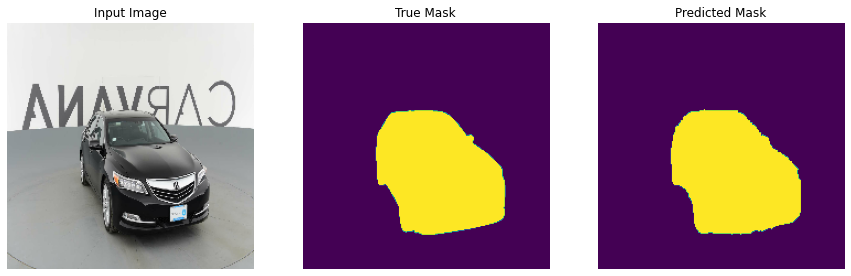

508/508 [==============================] - 890s 2s/step - loss: 0.0155 - accuracy: 0.9930 - val_loss: 0.0200 - val_accuracy: 0.9916
Epoch 6/20
508/508 [==============================] - 894s 2s/step - loss: 0.0143 - accuracy: 0.9934 - val_loss: 0.0193 - val_accuracy: 0.9919
Epoch 7/20
508/508 [==============================] - 883s 2s/step - loss: 0.0133 - accuracy: 0.9938 - val_loss: 0.0186 - val_accuracy: 0.9921
Epoch 8/20
508/508 [==============================] - 868s 2s/step - loss: 0.0126 - accuracy: 0.9940 - val_loss: 0.0187 - val_accuracy: 0.9922
Epoch 9/20
508/508 [==============================] - 860s 2s/step - loss: 0.0119 - accuracy: 0.9943 - val_loss: 0.0184 - val_accuracy: 0.9923
Epoch 10/20


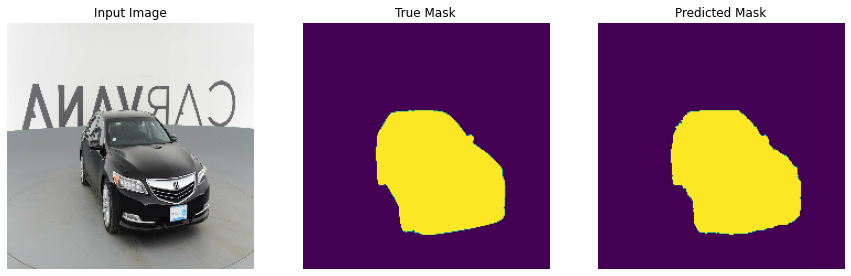

508/508 [==============================] - 869s 2s/step - loss: 0.0113 - accuracy: 0.9945 - val_loss: 0.0188 - val_accuracy: 0.9923
Epoch 11/20
508/508 [==============================] - 848s 2s/step - loss: 0.0108 - accuracy: 0.9947 - val_loss: 0.0191 - val_accuracy: 0.9922
Epoch 12/20
508/508 [==============================] - 844s 2s/step - loss: 0.0104 - accuracy: 0.9949 - val_loss: 0.0208 - val_accuracy: 0.9918
Epoch 13/20
508/508 [==============================] - 844s 2s/step - loss: 0.0101 - accuracy: 0.9950 - val_loss: 0.0273 - val_accuracy: 0.9898
Time taken in seconds is: 11129.0


In [34]:
# starting time (start timer)
start = timeit.default_timer()


# need to set seed for python core, numpy and tensorflow every time a neural network is ran to seed the neural network 

# set seed for python core
rnd.seed(123)

# set seed for numpy, keras takes random number generator from numpy
np.random.seed(123)

# set seed for tensorflow
tf.random.set_seed(1234)

# define the different layers in keras API

# instantiate the keras API model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = inputs

# Downsampling through the model
skips = down_stack(x)  # will return all the outputs from down_stack
x = skips[-1]          # returns the output from the last layer in down_stack (7,7,320) 
skips = reversed(skips[:-1])      # reversed(skips[:-1]) = skip last layer, take 4 layers counting from back, 
                                  # reverse the order
# layers in skips before reversing
# (112, 112, 96)
# (56, 56, 144)
# (28, 28, 192)
# (14, 14, 576)

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
    x = up(x)
    # use each layer from up_stack to upsample [x] (7,7,320)
    # (7,7,320) => (14, 14, 512)
    # (7,7,320) => (28, 28, 256)
    # (7,7,320) => (56, 56, 128)
    # (7,7,320) => (112, 112, 64)
    
    concat = tf.keras.layers.Concatenate()  # must be same shape for 0 and 1 axis to concatenate
    x = concat([x, skip])                   # concatenate each layer
    
# This is the last layer of the model
output_channels = 3   # indicate output channels
last = tf.keras.layers.Conv2DTranspose(     # doubles the dimension and decrease the layers
  output_channels, 3, strides=2,            # for this case, last layer(112, 112, 96) => (224, 224, 3)
  padding='same') 

outputs = last(x)

model_tl1 = keras.Model(inputs = inputs, outputs = outputs)

# compile the model
model_tl1.compile(optimizer = keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse categorical cross entropy used   
  metrics=["accuracy"])                                                 # because predicting for 3 layers
                                                                # from_logits=True to not convert output to logits
# fit the model
history_tl1 = model_tl1.fit(train_tf, epochs=20,
                          validation_data=val_tf,
                          callbacks=[DisplayCallback(), early_stopping_cb])

# end time (stop timer and print results)
stop = timeit.default_timer()

timeit.default_timer()

print(f'Time taken in seconds is: {round(stop - start,2)}')  

In [31]:
model_tl1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 112, 112, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

## Show what the model is predicting before training

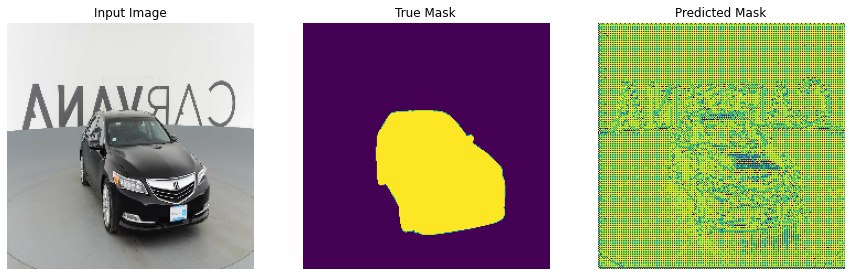

In [32]:
show_predictions(sample_image, sample_mask)

In [35]:
# Save the entire model as a SavedModel. (commented out to prevent overwriting)
# save_model_v2pix2pix = path('./models/v2_pix2pix120321')
# model_tl1.save(save_model_v2pix2pix)

INFO:tensorflow:Assets written to: models\v2_pix2pix120321\assets


In [119]:
# load model (commented out, uncomment to run)
# save_model_v2pix2pix = path('./models/v2_pix2pix')
# v2pix2pix_trained = tf.keras.models.load_model(save_model_v2pix2pix)

- As the model has not been trained, it is creating the mask from the input image, where the pixels have not been classified.

## Show predictions after training

**Show the original output**
- As the output is stated to be 3 in the model, there are 3 layers predicted 

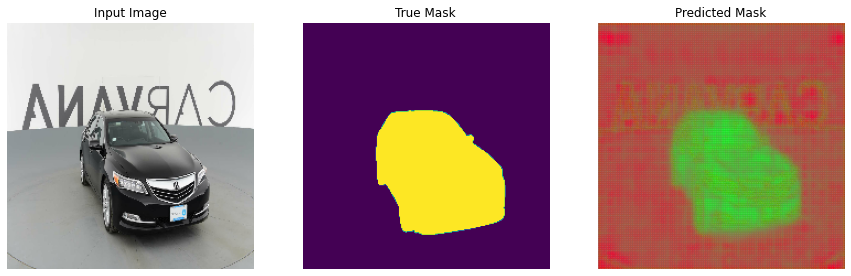

In [39]:
image_num = 1
pred_image_3channel = model_tl1.predict(image[image_num][tf.newaxis, ...])[0]
visualize([image[image_num], mask[image_num], pred_image_3channel])

In [36]:
# maximum and minimum values in theoutput of model_tl1
print(np.min(v2pix2pix_trained.predict(image[0][tf.newaxis, ...])))
print(np.max(v2pix2pix_trained.predict(image[0][tf.newaxis, ...])))

-13.68553
19.184465


- The activation function is not specified for the Conv2DTranspose in the last layer for model_tl1. Due to the activation of the filter, it resulted in the values to be between -13 and 19.

- Because the values are not in the range of 0 and 1, the loss function is not working as intended.

- As a result, the pixels are not classified properly to be signal (1) or background (0).

**Show individual channels from predicted image**

In [120]:
image, mask = next(iter(train_tf))
sample_image = image[1]
sample_mask = mask[1]

# individual masks
mask1 = v2pix2pix_trained.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 0]
mask2 = v2pix2pix_trained.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 1]

# background pixels
background = v2pix2pix_trained.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 2]

# overall image
overall = v2pix2pix_trained.predict(sample_image[tf.newaxis, ...])[0]

In [121]:
def visualize(display_list):
    plt.figure(figsize=(30, 20))
    title = ['True Mask', 'Mask 1', 'Mask 2', 'Background pixels', 'Overlay']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

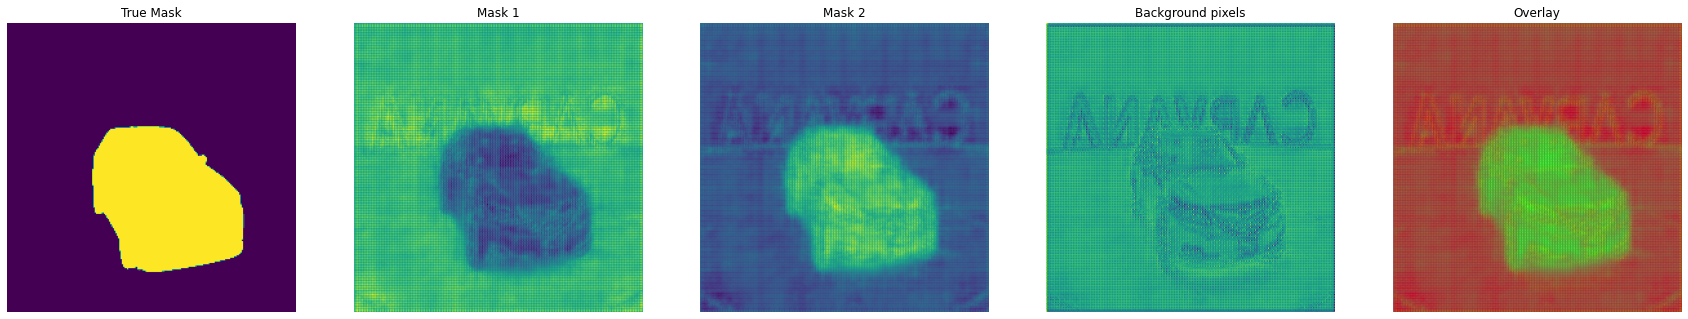

In [122]:
visualize([sample_mask, mask1, mask2, background, overall])

- By looking at the output, it can be seen clearly the pixels are not classified correctly due to no activation specified for Conv2D in the last layer.

**Show the mask output**
- Use tf.argmax(`image to be predicted`, axis=-1) to create the mask image.
- By using values from this code, ultimately it will indicate which pixel is black and which is white, hence creating a 1 channel mask.

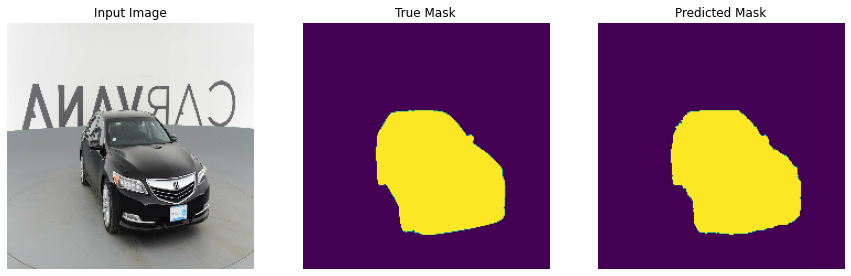

In [40]:
# show predictions after training
show_predictions(image[image_num], mask[image_num])

## Plot the train accuracy & loss, test accuracy & loss over epochs for model_tl1

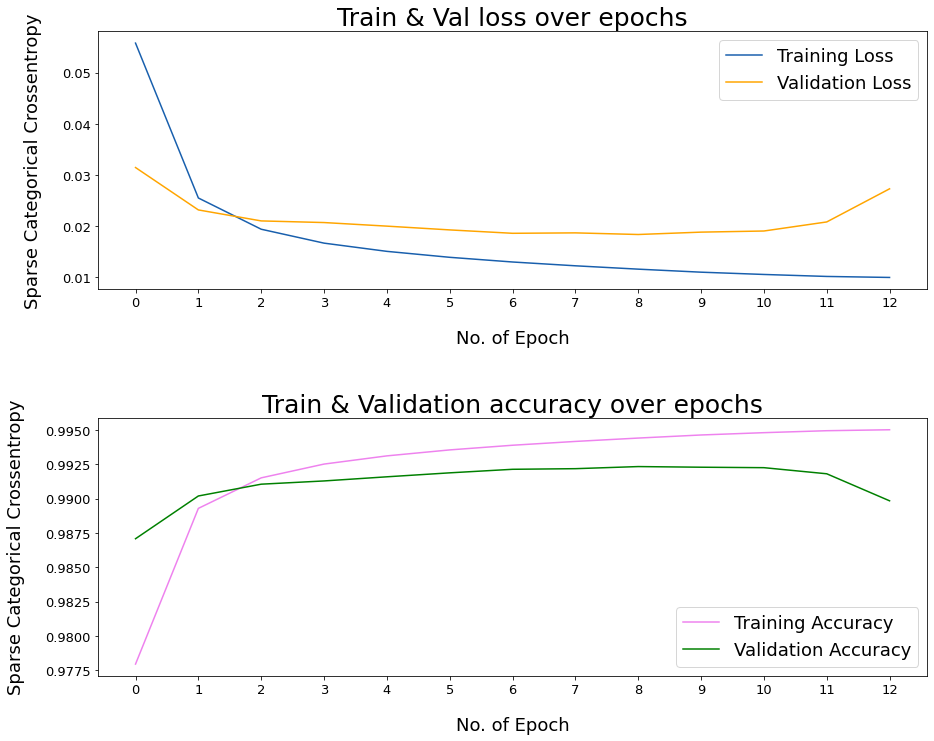

In [41]:
# Check train loss and test loss over epochs.
train_loss = history_tl1.history['loss']
val_loss = history_tl1.history['val_loss']
acc = history_tl1.history['accuracy']
val_acc = history_tl1.history['val_accuracy']
epochs_range = range(len(history_tl1.epoch))

# Set figure size.
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.01, right=0.97, top=0.96, bottom=0.065, hspace=0.5)

# Plot subplot for training, testing loss over epochs.
plt.subplot(2, 1, 1)
# 2 = 2 rows
# 1 = 1 column  epochs_range

plt.plot(epochs_range, train_loss, label='Training Loss', color='#185fad')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
# Set title
plt.title('Train & Val loss over epochs', fontsize = 25)
plt.xlabel('No. of Epoch', fontsize = 18, labelpad = 20)
plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, labelpad=20)
# set legend
plt.legend(fontsize = 18)
plt.xticks(ticks = list(range(history_tl1.epoch[0], history_tl1.epoch[-1]+1)), 
           labels = list(range(history_tl1.epoch[0], history_tl1.epoch[-1]+1)), fontsize = 13)
plt.yticks(fontsize = 13)

# Plot subplot for training, testing accuracy over epochs.
plt.subplot(2, 1, 2)
# 2 = 2 rows
# 1 = 1 column
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'violet')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = 'green')
plt.legend(fontsize = 18)
# Set title
plt.title('Train & Validation accuracy over epochs', fontsize = 25)
plt.xlabel('No. of Epoch', fontsize = 18, labelpad=20)
plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, labelpad=20)
# set legend
plt.legend(fontsize = 18)
plt.xticks(ticks = list(range(history_tl1.epoch[0], history_tl1.epoch[-1]+1)), 
           labels = list(range(history_tl1.epoch[0], history_tl1.epoch[-1]+1)), fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

- Due to early stopping included in the callback, the epoch with the best score is at epoch 9. The model is also reverted to the best weight.
- Model is saved to local drive.

# Re-define UNet CNN model - transfer learning
# MobilenetV2 + pix2pix `with` optimization
- the architecture of the CNN UNet is not optimized for the carvana image
- notably, the upsample layers are incorrect, the number of filters are not tuned according to the output
- this leads to mapping error when the downsampled layers and the upsampled layers are concatenated, as the depth of the downsampled layer and upsampled layer is different, although the model can be trained.

## Re-define downsampler encoder
- Use the same downsampler

In [31]:
# same downsampler as model_tl1

input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape= input_shape, include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64    output = (112, 112, 96)
    'block_3_expand_relu',   # 32x32    output = (56, 56, 144)
    'block_6_expand_relu',   # 16x16    output = (28, 28, 192)
    'block_13_expand_relu',  # 8x8      output = (14, 14, 576)
    'block_16_project',      # 4x4      Conv2D output = (7, 7, 320)
]
downstack_layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs= downstack_layers)

down_stack.trainable = False

## Re-define upsampler decoder
- modify the previous decoder so that the depth matches during concatenation

In [32]:
up_stack_redef = [                   # shape of layer to upsample = (7,7,320)
    
    # re-define arguments so that it matches output shape to the left
    pix2pix.upsample(576, 3),  # (14, 14, 576)
    pix2pix.upsample(192, 3),  # (28, 28, 192)
    pix2pix.upsample(144, 3),  # (56, 56, 144)
    pix2pix.upsample(96, 3),   # (112, 112, 96)
]

## Re-define callbacks for model

In [33]:
sample_image = image[1]
sample_mask = mask[1]

# this callback will show the prediction after every 4 epochs
class DisplayCallback_tl2(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions_tl2(sample_image, sample_mask)

In [34]:
# this callback will stop the training if there are no improvements to the val_loss score
# after 4 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True,
                                                    monitor='val_loss')

## Re-define function for predicting mask from image for model_tl2

In [35]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    # adds a new axis to the back of the array (1, 224, 224, 1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    # returns (224, 224, 1) so that image can be plotted
    return pred_mask[0]

def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions_tl2(sample_image, sample_mask):
    pred_mask = create_mask(model_tl2.predict(sample_image[tf.newaxis, ...]))
    visualize([sample_image, sample_mask, pred_mask])

## Construct and compile re-defined UNet CNN - transfer learning

Epoch 1/20
508/508 [==============================] - 713s 1s/step - loss: 0.1042 - accuracy: 0.9585 - val_loss: 0.0316 - val_accuracy: 0.9871
Epoch 2/20
508/508 [==============================] - 1100s 2s/step - loss: 0.0275 - accuracy: 0.9885 - val_loss: 0.0215 - val_accuracy: 0.9906
Epoch 3/20
508/508 [==============================] - 1165s 2s/step - loss: 0.0206 - accuracy: 0.9911 - val_loss: 0.0191 - val_accuracy: 0.9915
Epoch 4/20
508/508 [==============================] - 1142s 2s/step - loss: 0.0176 - accuracy: 0.9922 - val_loss: 0.0182 - val_accuracy: 0.9918
Epoch 5/20


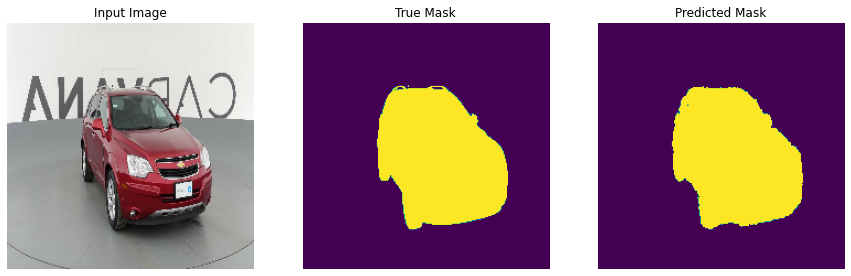

508/508 [==============================] - 1111s 2s/step - loss: 0.0158 - accuracy: 0.9928 - val_loss: 0.0184 - val_accuracy: 0.9918
Epoch 6/20
508/508 [==============================] - 1125s 2s/step - loss: 0.0145 - accuracy: 0.9933 - val_loss: 0.0183 - val_accuracy: 0.9919
Epoch 7/20
508/508 [==============================] - 1134s 2s/step - loss: 0.0135 - accuracy: 0.9937 - val_loss: 0.0170 - val_accuracy: 0.9924
Epoch 8/20
508/508 [==============================] - 1110s 2s/step - loss: 0.0126 - accuracy: 0.9940 - val_loss: 0.0166 - val_accuracy: 0.9926
Epoch 9/20
508/508 [==============================] - 1113s 2s/step - loss: 0.0119 - accuracy: 0.9943 - val_loss: 0.0162 - val_accuracy: 0.9928
Epoch 10/20


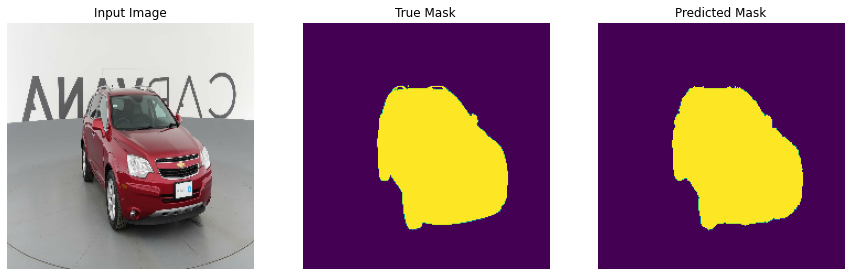

508/508 [==============================] - 1094s 2s/step - loss: 0.0112 - accuracy: 0.9945 - val_loss: 0.0157 - val_accuracy: 0.9930
Epoch 11/20
508/508 [==============================] - 1077s 2s/step - loss: 0.0107 - accuracy: 0.9947 - val_loss: 0.0158 - val_accuracy: 0.9931
Epoch 12/20
508/508 [==============================] - 1066s 2s/step - loss: 0.0103 - accuracy: 0.9949 - val_loss: 0.0167 - val_accuracy: 0.9929
Epoch 13/20
508/508 [==============================] - 1102s 2s/step - loss: 0.0102 - accuracy: 0.9949 - val_loss: 0.0181 - val_accuracy: 0.9926
Epoch 14/20
508/508 [==============================] - 1104s 2s/step - loss: 0.0102 - accuracy: 0.9949 - val_loss: 0.0182 - val_accuracy: 0.9923
Time taken in seconds is: 15156.0


In [56]:
# starting time (start timer)
start = timeit.default_timer()


# need to set seed for python core, numpy and tensorflow every time a neural network is ran to seed the neural network 

# set seed for python core
rnd.seed(123)

# set seed for numpy, keras takes random number generator from numpy
np.random.seed(123)

# set seed for tensorflow
tf.random.set_seed(1234)

# define the different layers in keras API

# instantiate the keras API model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = inputs

# Downsampling through the model
skips = down_stack(x)  # will return all the outputs from down_stack
x = skips[-1]          # returns the output from the last layer in down_stack (7,7,320) 
skips = reversed(skips[:-1])      # reversed(skips[:-1]) = skip last layer, take 4 layers counting from back, 
                                  # reverse the order
# layers in skips before reversing
# (112, 112, 96)
# (56, 56, 144)
# (28, 28, 192)
# (14, 14, 576)

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack_redef, skips):
    x = up(x)
    # use each layer from up_stack to upsample [x] (7,7,320)
    # (7,7,320) => (14, 14, 576)
    # (7,7,320) => (28, 28, 192)
    # (7,7,320) => (56, 56, 144)
    # (7,7,320) => (112, 112, 96)
    
    concat = tf.keras.layers.Concatenate()  # must be same shape for 0 and 1 axis to concatenate
    x = concat([x, skip])                   # concatenate each layer
    
# This is the last layer of the model
output_channels = 3   # indicate output channels
last = tf.keras.layers.Conv2DTranspose(     # doubles the dimension and decrease the layers
  output_channels, 3, strides=2,            # for this case, last layer(112, 112, 96) => (224, 224, 3)
  padding='same', activation = 'sigmoid')   # sigmoid activation to convert pixel output values to be between 0 and 1.

outputs = last(x)

model_tl2 = keras.Model(inputs = inputs, outputs = outputs)

# compile the model
model_tl2.compile(optimizer = keras.optimizers.Adam(),        # set from_logits=True to not convert pred values into logit
                                                              # (between 0 and 1)
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Sparse cross entropy used because
                                                                         # predicting for 3 layers
  metrics=["accuracy"])                                       
# fit the model
history_tl2 = model_tl2.fit(train_tf, epochs=20,
                          validation_data=val_tf,
                          callbacks=[DisplayCallback_tl2(), early_stopping_cb])

# end time (stop timer and print results)
stop = timeit.default_timer()

timeit.default_timer()

print(f'Time taken in seconds is: {round(stop - start,2)}')  

In [53]:
model_tl2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 112, 112, 96 1841984     input_5[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 576)  1661184     model[3][4]                      
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 14, 14, 1152) 0           sequential[3][0]                 
                                                                 model[3][3]                

In [57]:
# Save the entire model as a SavedModel. (commented out to prevent overwriting)
# save_model_v2pix2pix = path('./models/v2_pix2pix_final_3channel')
# model_tl2.save(save_model_v2pix2pix)

INFO:tensorflow:Assets written to: models\v2_pix2pix_final_3channel\assets


## Show what the model_tl2 is predicting before training

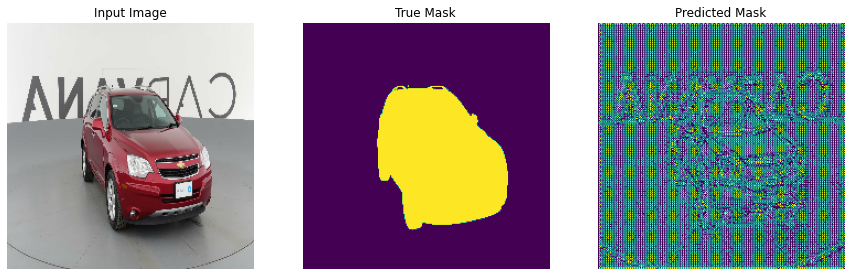

In [55]:
show_predictions_tl2(sample_image, sample_mask)

- As the model has not been trained, it is creating the mask from the input image, where the pixels have not been classified.

## Show model_tl2 predictions after training
**Show the original output**

Same as previous, as the output is stated to be 3 in the model, there are 3 layers predicted

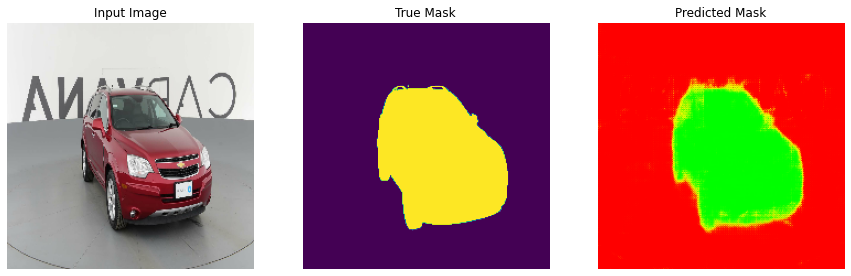

In [58]:
image_num = 1
pred_image_3channel = model_tl2.predict(image[image_num][tf.newaxis, ...])[0]
visualize([image[image_num], mask[image_num], pred_image_3channel])

In [51]:
# load the saved model (uncomment to load model)
# save_model_v2pix2pix_final = path('./models/v2_pix2pix_final_3channel')
# v2pix2pix_final = tf.keras.models.load_model(save_model_v2pix2pix_final)

In [43]:
# values in predicted image are between 0 and 1 due to sigmoid activation
print(np.min(v2pix2pix_final.predict(image[0][tf.newaxis, ...])))
print(np.max(v2pix2pix_final.predict(image[0][tf.newaxis, ...])))

2.7764247e-11
1.0


**Show individual channels from predicted image**

In [100]:
image, mask = next(iter(train_tf))
sample_image = image[1]
sample_mask = mask[1]

# individual masks
mask1 = v2pix2pix_final.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 0]
mask2 = v2pix2pix_final.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 1]

# background pixels
background = v2pix2pix_final.predict(sample_image[tf.newaxis, ...])[... , tf.newaxis][0, :, :, 2]

# overall image
overall = v2pix2pix_final.predict(sample_image[tf.newaxis, ...])[0]

In [117]:
def visualize(display_list):
    plt.figure(figsize=(30, 20))
    title = ['True Mask', 'Mask 1', 'Mask 2', 'Background pixels', 'Overlay']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

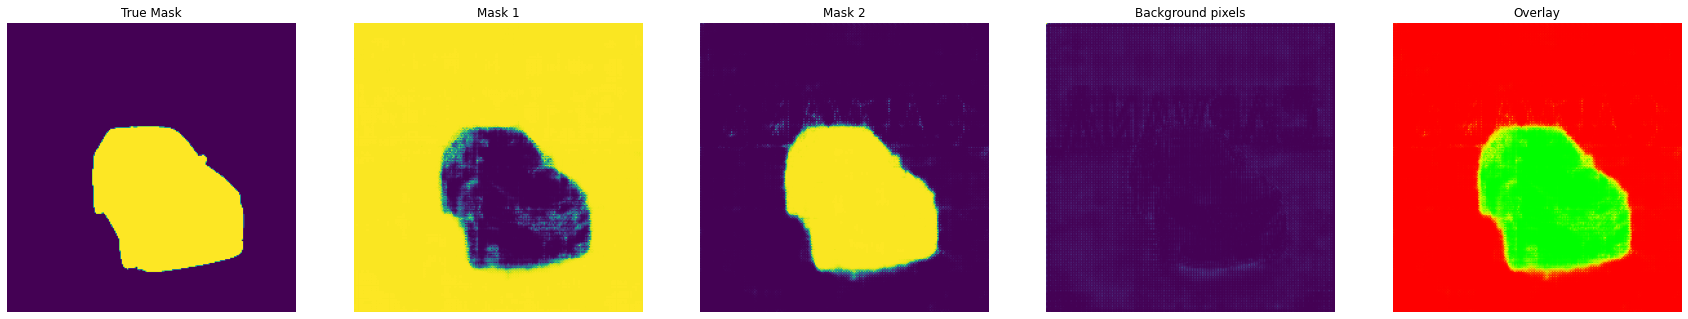

In [118]:
visualize([sample_mask, mask1, mask2, background, overall])

- The activation function is specified for the Conv2DTranspose in the last layer for model_tl2. Even with the activation of the filter, the activation function in the Conv2DTranspose will convert the values between 0 and 1, as shown above.


- After training, the pixels are classified according to the mask label. Pixels classified as red is the background (0) and pixels classified as green (1) is the signal. Yellow is the overlap of red and green at equal intensity. There are 2 classes of pixel, 0 and 1 in the mask but the output from the model is 3. 


- From here, we are able to see there are some overlaps between the pixels labeled as background and pixels labeled as the mask of the car. There are 2 mask layers overlapping. 


- In Mask 1, there are some background pixels misclassified as signal. In Mask 2, there are some signal pixels misclassified as background.


- From the overlay, it can be seen Mask 1 is less accurate than Mask 2 is less accurate than Mask 1, as more of the pixels (yellow) are misclassified as background. However, Mask 2 is more defined than Mask 1.

## Show model_tl2 predictions after training

**Show the mask output**
- Use tf.argmax(`image to be predicted`, axis=-1) to create the mask image.
- By using values from this code, ultimately it will indicate which pixel is black and which is white, hence creating a 1 channel mask.
- With the create mask function the mask generated is taking the pixels classified in the last layer.

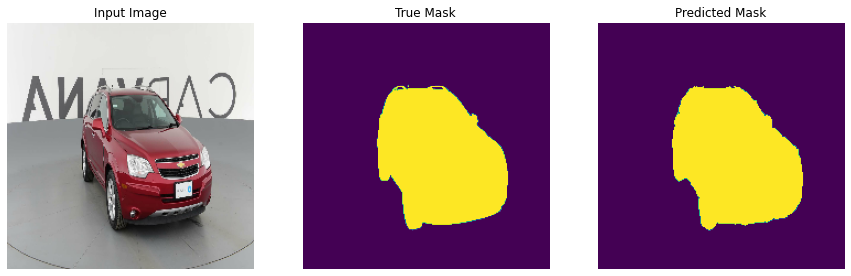

In [59]:
# show predictions after training
show_predictions_tl2(image[image_num], mask[image_num])

## Plot the train accuracy & loss, test accuracy & loss over epochs for model_tl2

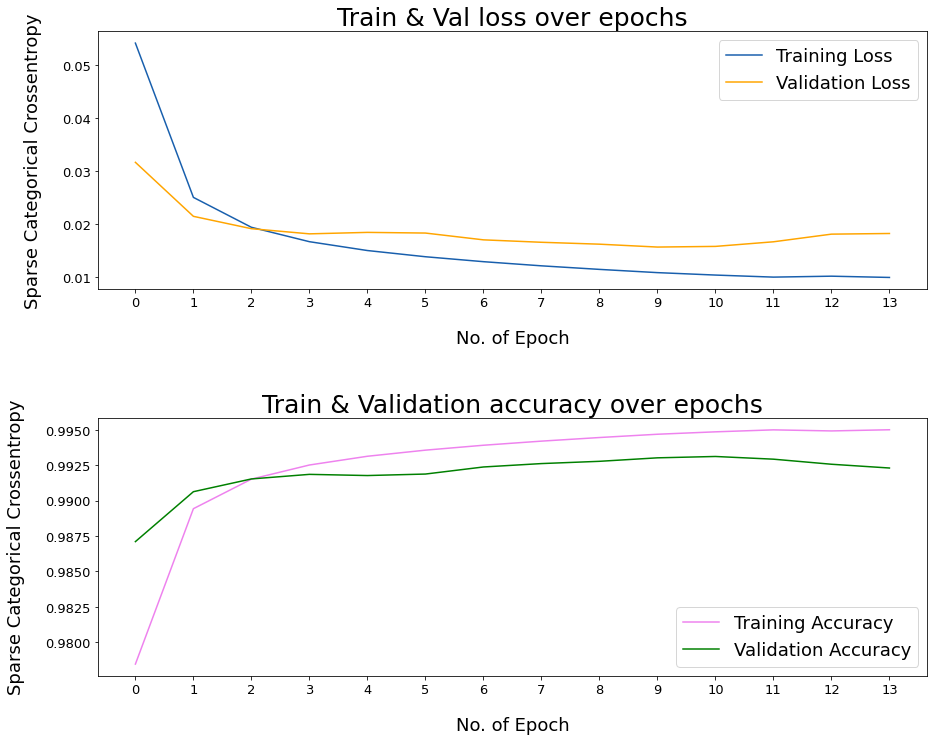

In [60]:
# Check train loss and test loss over epochs.
train_loss = history_tl2.history['loss']
val_loss = history_tl2.history['val_loss']
acc = history_tl2.history['accuracy']
val_acc = history_tl2.history['val_accuracy']
epochs_range = range(len(history_tl2.epoch))

# Set figure size.
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.01, right=0.97, top=0.96, bottom=0.065, hspace=0.5)

# Plot subplot for training, testing loss over epochs.
plt.subplot(2, 1, 1)
# 2 = 2 rows
# 1 = 1 column  epochs_range

plt.plot(epochs_range, train_loss, label='Training Loss', color='#185fad')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
# Set title
plt.title('Train & Val loss over epochs', fontsize = 25)
plt.xlabel('No. of Epoch', fontsize = 18, labelpad = 20)
plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, labelpad=20)
# set legend
plt.legend(fontsize = 18)
plt.xticks(ticks = list(range(history_tl2.epoch[0], history_tl2.epoch[-1]+1)), 
           labels = list(range(history_tl2.epoch[0], history_tl2.epoch[-1]+1)), fontsize = 13)
plt.yticks(fontsize = 13)

# Plot subplot for training, testing accuracy over epochs.
plt.subplot(2, 1, 2)
# 2 = 2 rows
# 1 = 1 column
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'violet')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = 'green')
plt.legend(fontsize = 18)
# Set title
plt.title('Train & Validation accuracy over epochs', fontsize = 25)
plt.xlabel('No. of Epoch', fontsize = 18, labelpad=20)
plt.ylabel('Sparse Categorical Crossentropy', fontsize = 18, labelpad=20)
# set legend
plt.legend(fontsize = 18)
plt.xticks(ticks = list(range(history_tl2.epoch[0], history_tl2.epoch[-1]+1)), 
           labels = list(range(history_tl2.epoch[0], history_tl2.epoch[-1]+1)), fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

- Due to early stopping included in the callback, the epoch with the best score is at epoch 10. The model is also reverted to the best weight.
- Model is saved to local drive.

# Define UNet CNN model - transfer learning
# VGG19 + pix2pix optimized
- tweak the model to fit the Carvana dataset
- the encoder layers are obtained from the VGG19 neural net
- the decoder layers are derived from Tensorflow pix2pix example upsample function

model is adapted from https://www.kaggle.com/yacinerouizi/carvana-vgg19-u-net

## Re-create dataset with 512 x 512 resolution

In [67]:
# create training and validation tensorflow dataset
# from_tensor_slices is used so that data can feed in batches
# from_tensors feed all of the data into the model and not able to split into batches
train_tf = tf.data.Dataset.from_tensor_slices((train_df['train_path'].values, train_df['mask_path'].values))
val_tf = tf.data.Dataset.from_tensor_slices((val_df['train_path'].values, val_df['mask_path'].values)) 

**Create function to process training and validation tensorflow dataset**

In [68]:
IMG_SIZE = [512,512]
batch_size = 8

def decode(path):
    
    # take in path string
    img = tf.io.read_file(path) 
    
    # convert the compressed string to a 3D uint8 tensor
    # must use decode_jpeg method to return tensor shape, to resize image later
    # tf.image.decode_image method does not return tensor shape
    img = tf.image.decode_jpeg(img, channels=3)
    
    # original size (1918, 1280)
    # resize to square (1024, 1024)
    img = tf.image.resize(img, IMG_SIZE)
    
    # scale the RGB values so that the values are normalized between 0 and 1
    img = img / 255.0
    return img

@tf.function  # designates below function as tensorflow function so that it is independent of python
def preprocess(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    image = decode(image_path)
    mask = decode(mask_path)
    mask = mask[:, :, :1]  # take only 1 channel
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

@tf.function  # designates below function as tensorflow function so that it is independent of python
def data_augmentation(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image_path)
        mask = tf.image.flip_left_right(mask_path)
        
    else:
        image = tf.image.flip_up_down(image_path)        
        mask = tf.image.flip_up_down(mask_path)
        
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

def batch_data(dataset):
    dataset = dataset.cache().batch(batch_size)
    dataset = dataset.prefetch(buffer_size=1)
    return dataset

In [69]:
# process training and validation tensorflow data
train_tf = train_tf.map(preprocess)
train_tf = train_tf.map(data_augmentation)
train_tf = batch_data(train_tf)

val_tf = val_tf.map(preprocess)
val_tf = batch_data(val_tf)

In [70]:
train_tf

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

## Define downsampler encoder

In [18]:
from tensorflow.keras.applications import VGG19

vgg19_basemodel = VGG19(input_shape=(512, 512, 3), include_top=False, weights="imagenet")

layers_names = [       # output shape
    "block2_conv1",    # (640, 640, 128)
    "block2_conv2",    # (640, 640, 128)
    "block3_conv1",    # (320, 320, 256)
    "block3_conv2",    # (320, 320, 256)
    "block4_conv1",    # (160, 160, 512)
    "block4_conv2",    # (160, 160, 512)
    "block5_conv1",    # (80, 80, 512)
]

output_layers = [vgg19_basemodel.get_layer(name).output for name in layers_names]
downstack_vgg19 = Model(inputs=vgg19_basemodel.input, outputs=output_layers)

# set trainable to False to prevent weights from being updated
downstack_vgg19.trainable = False

In [19]:
vgg19_basemodel.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

- Based on the layers in the base model, the conv1 and conv2 are assumed to be the feature extraction layers. Conv3 and conv4 layers are the learning layers to consolidate features extracted and maintain the information learnt by the previous layers.

- It will be good to use all the layers, for my purpose I am trying to build a shorter net and have a shorter training time.

In [35]:
downstack_vgg19.outputs

[<KerasTensor: shape=(None, 256, 256, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 512) dtype=float32 (created by layer 'block4_conv2')>,
 <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block5_conv1')>]

- Above are the outputs by each layer in the downstacking

## Define upsampler decoder

In [20]:
def upsample_vgg19(filters, size, strides):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=strides,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    # ReLu activation to help with model learning and mitigate vanishing gradient problem
    result.add(tf.keras.layers.ReLU())
    
    return result

upstack_vgg19 = [              
    
    upsample_vgg19(512, 3, 1),  
    upsample_vgg19(512, 3, 2),  
    upsample_vgg19(256, 3, 1),  
    upsample_vgg19(256, 3, 2), 
    upsample_vgg19(128, 3, 1),  
    upsample_vgg19(128, 3, 2),  
]

## Re-define callbacks for model

In [22]:
image, mask = next(iter(train_tf))

In [23]:
sample_image = image[1]
sample_mask = mask[1]

# this callback will show the prediction after every 4 epochs
class DisplayCallback_vgg19(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions_vgg19(sample_image, sample_mask)

In [24]:
# this callback will stop the training if there are no improvements to the val_loss score
# after 4 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True,
                                                    monitor='val_loss')

## Re-define function for predicting mask from image for model_vgg19

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    # adds a new axis to the back of the array (1, 512, 512, 1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    # returns (512, 512, 1) so that image can be plotted
    return pred_mask[0]

def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions_vgg19(sample_image, sample_mask):
    pred_mask = create_mask(model_vgg19.predict(sample_image[tf.newaxis, ...]))
    visualize([sample_image, sample_mask, pred_mask])

## VGG19: Construct and compile re-defined UNet CNN - transfer learning

In [29]:
# starting time (start timer)
start = timeit.default_timer()


# need to set seed for python core, numpy and tensorflow every time a neural network is ran to seed the neural network 

# set seed for python core
rnd.seed(123)

# set seed for numpy, keras takes random number generator from numpy
np.random.seed(123)

# set seed for tensorflow
tf.random.set_seed(1234)

# define the different layers in keras API

# instantiate the keras API model
inputs = tf.keras.Input(shape = (512, 512, 3))
x = inputs

# Downsampling through the model
skips = downstack_vgg19(x)  # will return all the outputs from down_stack
x = skips[-1]          # returns the output from the last layer in down_stack (32,32,512) 
skips = reversed(skips[:-1])      

# Upsampling and establishing the skip connections
for up, skip in zip(upstack_vgg19, skips):
    x = up(x)
    if up.layers[0].strides == (2, 2):
    
    # initial layer to upstack (32, 32, 512)   only the paired layer with s=2 will be concatenated
    # (32, 32, 512)   => (64, 64, 512) s = 2
    # (32, 32, 512) x 2 => (64 ,64, 1024)
    
    # (64 ,64, 1024) => (128, 128, 256) s = 2
    # (128, 128, 256) x 2 => (128, 128, 512)
    
    # (128, 128, 512) => (256, 256, 128) s = 2
    # (256, 256, 128) x 2 => (256, 256, 256)
    
        concat = tf.keras.layers.Concatenate()  # must be same shape for 0 and 1 axis to concatenate
        x = concat([x, skip])                   # concatenate each layer
    
# This is the last layer of the model
output_channels = 3   # indicate output channels
last = tf.keras.layers.Conv2DTranspose(     # doubles the dimension and decrease the layers
  output_channels, 3, strides=2,            # for this case, last layer(256, 256, 256) => (512, 512, 3)
  padding='same', activation = "sigmoid") 

outputs = last(x)

model_vgg19 = keras.Model(inputs = inputs, outputs = outputs)

# compile the model
model_vgg19.compile(optimizer = keras.optimizers.Adam(),        
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   
  metrics=["accuracy"])                                                 
        
# fit the model
history_vgg19 = model_vgg19.fit(train_tf, epochs=20,
                          validation_data=val_tf,
                          callbacks=[DisplayCallback_vgg19(), early_stopping_cb])

# end time (stop timer and print results)
stop = timeit.default_timer()

timeit.default_timer()

print(f'Time taken in seconds is: {round(stop - start,2)}')  

Epoch 1/20
  2/508 [..............................] - ETA: 1:30:05 - loss: 1.2594 - accuracy: 0.3911

KeyboardInterrupt: 

- The initial epoch takes around 1 hour 30 minutes to train on the local machine. The model is not trained.

In [27]:
model_vgg19.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 256, 256, 12 12944960    input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 512)  2361344     model[0][6]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 512)  2361344     sequential[0][0]                 
____________________________________________________________________________________________

## Show predictions before training

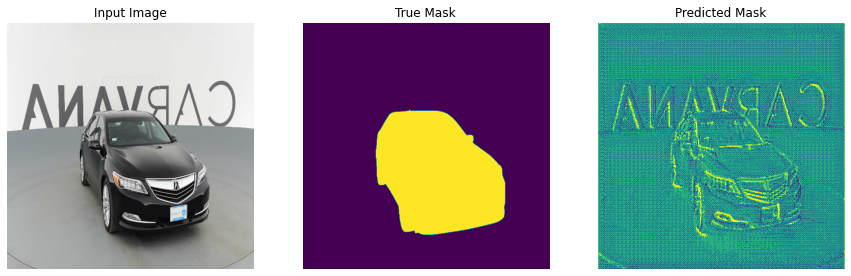

In [28]:
show_predictions_vgg19(sample_image, sample_mask)

- It can be seen the true mask is more defined at higher resolution. Similarly the predicted mask will have a higher resolution as well.

# Build CNN UNet model from scratch

UNet is adapted from [petrosgk](https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge/blob/master/model/u_net.py) github repository.

## Re-create datasets to create a 1 channel input

In [40]:
# create training and validation tensorflow dataset
# from_tensor_slices is used so that data can feed in batches
# from_tensors feed all of the data into the model and not able to split into batches
train_tf = tf.data.Dataset.from_tensor_slices((train_df['train_path'].values, train_df['mask_path'].values))
val_tf = tf.data.Dataset.from_tensor_slices((val_df['train_path'].values, val_df['mask_path'].values)) 

## Create function to decode image and masks separately

In [41]:
IMG_SIZE = [224, 224]
batch_size = 8
BUFFER_SIZE = 1000

def decode(path, gif=False):
    
    # take in path string
    img = tf.io.read_file(path) 
    
    # convert the compressed string to a 3D uint8 tensor
    # must use decode_jpeg method to return tensor shape, to resize image later
    # tf.image.decode_image method does not return tensor shape
    if gif:
        img = tf.image.decode_jpeg(img, channels=3)
    else:
        img = tf.image.decode_jpeg(img, channels=1)
    
    # original size (1918, 1280)
    # resize to square (1024, 1024)
    img = tf.image.resize(img, IMG_SIZE)
    
    # scale the RGB values so that the values are normalized between 0 and 1
    img = img / 255.0
    return img

@tf.function  # designates below function as tensorflow function so that it is independent of python
def preprocess(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    image = decode(image_path)
    mask = decode(mask_path, gif=True)
    mask = mask[:, :, :1]  # take only 1 channel
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

@tf.function  # designates below function as tensorflow function so that it is independent of python
def data_augmentation(image_path, mask_path):    # takes in 2 arguments, specifically image_path and mask_path together
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image_path)
        mask = tf.image.flip_left_right(mask_path)
        
    else:
        image = tf.image.flip_up_down(image_path)        
        mask = tf.image.flip_up_down(mask_path)
        
    return image, mask    # after processing, will return tensorflow dataset with 2 'features'

def batch_data(dataset):
    dataset = dataset.cache().batch(batch_size)
    dataset = dataset.prefetch(buffer_size=1)
    return dataset

## Re-create training and validation tensorflow datasets

In [42]:
# process training and validation tensorflow data
train_tf = train_tf.map(preprocess)
train_tf = train_tf.map(data_augmentation)
train_tf = batch_data(train_tf)

val_tf = val_tf.map(preprocess)
val_tf = batch_data(val_tf)

In [43]:
train_tf

<PrefetchDataset shapes: ((None, 224, 224, 1), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

## Define CNN UNet model - Build from scratch

In [34]:
# when padding, output_shape = input_shape / strides
# when no padding, output shape = (input_shape - pool_size + 1) / strides 
# eg input shape = 80 x 80, output shape = (80 - 3 + 1) / 2 = 39

def get_unet_224x224(input_shape=(224, 224, 1),
                  num_classes=1):
    inputs = tf.keras.Input(shape = input_shape)
    # 224

    down1 = Conv2D(32, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(32, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)                           # 224 x 224 x 32
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 112 

    down2 = Conv2D(64, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(64, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)                           # 112 x 112 x 64
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 64 

    down3 = Conv2D(128, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(128, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)                           # 64 x 64 x 128
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 32

    down4 = Conv2D(256, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(256, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)                          # 32 x 32 x 256
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 16

    center = Conv2D(512, (3, 3), padding='same')(down4_pool)  # 16 x 16 x 512
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(512, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center
                                                                                    # center layer = 16 x 16 x 512
    up4 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(center)     # after transpose = 32 x 32 x 256
    up4 = concatenate([down4, up4], axis=3)    # up4 = 32,32,256   # down4 = 32,32,256  #concat = 32,32,512
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 32

    up3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(up4)   # 64 x 64 x 128
    up3 = concatenate([down3, up3], axis=3)     # up3 = 64,64,128   # down3 = 64,64,128  #concat = 64,64,256
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 64

    up2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(up3)  # 112 x 112 x 64
    up2 = concatenate([down2, up2], axis=3)     # up2 = 112,112,64   # down2 = 112,112,64   #concat = 112,112,128
    up2 = Conv2D(32, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(32, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(32, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 112

    up1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(up2)  # 224 x 224 x 32
    up1 = concatenate([down1, up1], axis=3)    # up1 = 224,224,32   # down1 = 224,224,32  #concat = 224,224,64
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 224

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer = keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    return model   

In [35]:
Unet_224 = get_unet_224x224()

In [36]:
Unet_224.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

## Construct and compile CNN model

## Re-define display functions

In [38]:
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions_unet224(sample_image, sample_mask):
    pred_mask = Unet_224.predict(sample_image[tf.newaxis, ...])[0]
    visualize([sample_image, sample_mask, pred_mask])

## Re-define callbacks for model

In [45]:
image, mask = next(iter(train_tf))

In [46]:
sample_image = image[1]
sample_mask = mask[1]

# this callback will show the prediction after every 4 epochs
class DisplayCallback_unet224(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions_unet224(sample_image, sample_mask)

In [47]:
# this callback will stop the training if there are no improvements to the val_loss score
# after 4 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                    restore_best_weights=True,
                                                    monitor='val_loss')

## Show what the model is predicting before training

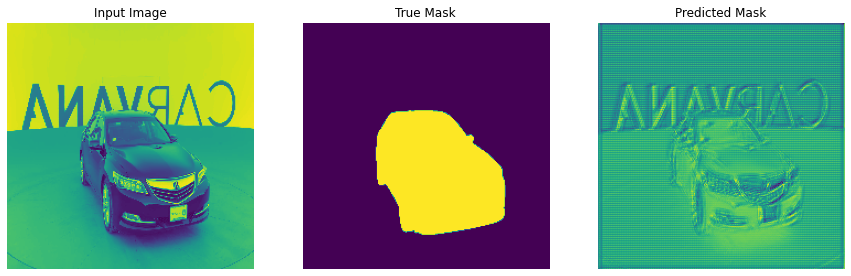

In [48]:
show_predictions_unet224(sample_image, sample_mask)

- As the input layer is 1 and the pixel values are between 0 and 1, the predicted mask shows the pixels are not segregated yet.

In [49]:
# fit model
history_Unet224 = Unet_224.fit(train_tf, epochs= 20,
                          validation_data=val_tf,
                          callbacks=[DisplayCallback_unet224(), early_stopping_cb])


Epoch 1/20
  2/508 [..............................] - ETA: 30:30 - loss: 0.6961 - accuracy: 0.6091

KeyboardInterrupt: 

- The initial epoch takes around 30 minutes to train on the local machine. This is much longer than UNet CNN built using transfer learning. The model is not trained.

# Generate .csv file for submission
- Run length encoding (rle) is taken from this [notebook](https://www.kaggle.com/stainsby/fast-tested-rle).

In [136]:
def rle_encode2(image):
    """
    receives a masked image and encodes it to RLE
    :param mask_image:
    :return: string corresponding to the rle of the input image
    """
    
    # tf.reshape(image, -1) flattens the image array
    # .numpy() method converts tensorflow array to numpy array otherwise cannot assign values to pixels[0] and [-1]
    pixels = tf.reshape(image, -1).numpy()
    
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [132]:
trainmaskcsv = pd.read_csv("./mask/train_masks.csv")
trainmaskcsv.loc[0, "rle_mask"]

'879386 40 881253 141 883140 205 885009 17 885032 259 886923 308 888839 328 890754 340 892670 347 894587 352 896503 357 898420 360 900336 364 902253 367 904170 370 906086 374 908003 377 909920 379 911837 381 913754 384 915671 386 917588 388 919505 391 921422 393 923339 395 925256 397 927173 399 929090 401 931007 403 932925 404 934842 406 936759 408 938676 410 940593 412 942510 414 944428 415 946345 416 948262 418 950179 420 952097 421 954014 423 955931 425 957848 426 959766 427 961683 429 963600 431 965517 432 967435 433 969352 435 971269 437 973186 438 975104 439 977021 441 978938 442 980855 444 982773 445 984690 447 986607 448 988525 449 990442 451 992359 452 994277 453 996194 455 998111 456 1000028 458 1001946 459 1003863 460 1005780 462 1007698 463 1009615 464 1011532 466 1013450 467 1015367 468 1017284 470 1019202 471 1021119 472 1023036 474 1024954 475 1026871 476 1028788 478 1030706 479 1032623 480 1034540 482 1036458 482 1038375 484 1040292 486 1042210 486 1044127 488 1046044 4

- The run length encoded resized image should look similar to the one in the train_masks csv file.

## Preprocessing test data

In [123]:
IMG_SIZE = [224,224]

@tf.function
def test_decode(path):
    
    # take in path string
    img = tf.io.read_file(path) 
    
    # convert the compressed string to a 3D uint8 tensor
    # must use decode_jpeg method to return tensor shape, to resize image later
    # tf.image.decode_image method does not return tensor shape
    img = tf.image.decode_jpeg(img, channels=3)
    
    # resize image to (224,224)
    img = tf.image.resize(img, IMG_SIZE)
    
    # scale the RGB values so that the values are normalized between 0 and 1
    img = img / 255.0
    
    # add a new axis to the array since data is trained on (None, 224, 224, 3) due to batching
    # after adding new axis shape will be (1, 224, 224, 3)
    img = img[tf.newaxis, ...]
    return img

## Create tensorflow dataset from test data

In [124]:
# create a tensorflow dataset with file names from test_data
# function search for files similar to glob
test_tf = tf.data.Dataset.list_files(str(path.joinpath(test_data, "*.jpg")), shuffle=False)
len(test_tf)

100064

In [125]:
# decode test data and convert images into tensorflow objects
test_tf = test_tf.map(test_decode)
test_tf

<MapDataset shapes: (1, 224, 224, 3), types: tf.float32>

## Predict mask from 1 test image

In [126]:
for a in test_tf:
    abc224 = a
    break

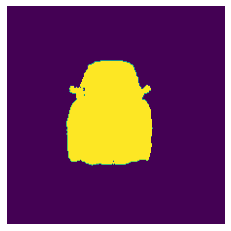

In [130]:
plt.imshow(create_mask(v2pix2pix_final.predict(abc224)))
plt.axis("off")
plt.show()

## Test run length encoder

(1, 224, 224)
(224, 224, 1)
(1912, 1280, 1)


'612390 131 613670 131 614950 131 616230 131 617510 131 618790 131 620070 131 621350 131 622630 131 623875 189 625155 189 626435 189 627715 189 628995 189 630275 189 631555 189 632835 189 634110 211 635390 211 636670 211 637950 211 639230 211 640510 211 641790 211 643070 211 644350 211 645618 229 646898 229 648178 229 649458 229 650738 229 652018 229 653298 229 654578 229 655841 257 657121 257 658401 257 659681 257 660961 257 662241 257 663521 257 664801 257 666081 257 667355 269 668635 269 669915 269 671195 269 672475 269 673755 269 675035 269 676315 269 677595 269 678875 269 680155 269 681435 269 682715 269 683995 269 685275 269 686555 269 687835 269 689115 275 690395 275 691675 275 692955 275 694235 275 695515 275 696795 275 698075 275 699355 275 700635 275 701915 275 703195 275 704475 275 705755 275 707035 275 708315 275 709595 275 710870 280 712150 280 713430 280 714710 280 715990 280 717270 280 718550 280 719830 280 721104 291 722384 291 723664 291 724944 291 726224 291 727504 29

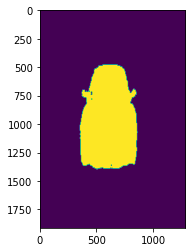

In [137]:
yt = tf.argmax(v2pix2pix_final.predict(abc224), axis = -1)
print(yt.shape)

# reshape to facilitate correct resizing later
yt = tf.reshape(yt, [224, 224, 1])
print(yt.shape)

# resize to (1912,1280, 1)
ty = tf.image.resize(yt, [1912, 1280], method = 'nearest')
print(ty.shape)

plt.imshow(ty)
rle_encode2(ty)

- Predicted mask that is run length encoded looks similar to that in train_masks.csv

# For 3 layer output

In [74]:
# starting time
start = timeit.default_timer()

resize_submit = [1912, 1280]
test_pred_data = []
count = 0

for test_image in test_tf:
    # predict and create mask from image using trained model
    # image shape = (1, 224, 224)
    test_image_pred = tf.argmax(model_tl2.predict(test_image), axis = -1)
    
    # reshape to facilitate correct resizing later
    # image shape = (224, 224, 1)
    test_image_pred = tf.reshape(test_image_pred, [224, 224, 1])
    
    # resize image to (1912,1280, 1)
    test_image_pred = tf.image.resize(test_image_pred, resize_submit, method = 'nearest')
    
    # rle_encode mask
    test_image_pred = rle_encode2(test_image_pred)
    
    # append to list
    test_pred_data.append(test_image_pred)
    
#     count += 1
#     if count == 3: break
        
# end time (stop timer and print results)
stop = timeit.default_timer()

timeit.default_timer()

print(f'Time taken in seconds is: {round(stop - start,2)}')  

Time taken in seconds is: 12267.0


- The time taken on a local machine to predict the mask and run length encode all 100, 064 test images is around 3.5 hours.

- The rle encoded test images will be put into a list, each entry is a string.

**The data will first be put into a pandas dataframe.**

In [76]:
# export to .csv
export_csv = pd.DataFrame({"img" : os.listdir(test_data),
              "rle_mask": test_pred_data})
export_csv

img                                           rle_mask
0       0004d4463b50_01.jpg  612390 131 613670 131 614950 131 616230 131 61...
1       0004d4463b50_02.jpg  612390 137 612567 5 613670 137 613847 5 614950...
2       0004d4463b50_03.jpg  612401 23 612435 86 613681 23 613715 86 614961...
3       0004d4463b50_04.jpg  612458 74 613738 74 615018 74 616298 74 617578...
4       0004d4463b50_05.jpg  612447 74 613727 74 615007 74 616287 74 617567...
...                     ...                                                ...
100059  fff341f26a19_12.jpg  491675 6 492955 6 494235 6 495515 6 496795 6 4...
100060  fff341f26a19_13.jpg  491675 6 492955 6 494235 6 495515 6 496795 6 4...
100061  fff341f26a19_14.jpg  491675 6 492955 6 494235 6 495515 6 496795 6 4...
100062  fff341f26a19_15.jpg  503195 6 504475 6 505755 6 507035 6 508315 6 5...
100063  fff341f26a19_16.jpg  491675 6 492955 6 494235 6 495515 6 496795 6 4...

[100064 rows x 2 columns]

**After that it will be exported as a .csv file.**

In [77]:
# uncomment to export file
#export_csv.to_csv("submit_224x224_resize_nearest_v2pix2pix_optimized.csv", index = False)

# Conclusion

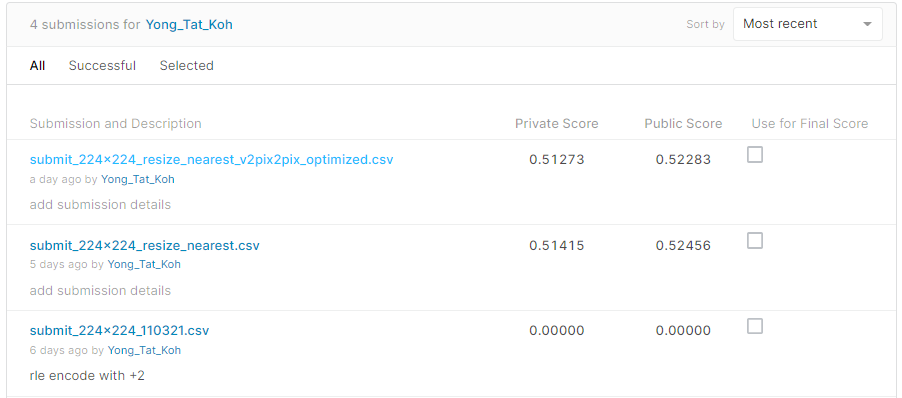

- The Kaggle score obtained is around 0.52.


- Models that accomodate for higher resolution input image can be trained to achieve true upscaling for the predicted masks instead of using TensorFlow resizing method.


- Other platforms with more advanced and powerful computational power can be used to train the models to reduce training time.